In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, dpi_save=500, format='pdf')

scanpy==1.4 anndata==0.6.18 numpy==1.16.1 scipy==1.2.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
adata = sc.read_h5ad("adata.h5ad")

In [4]:
adata.var_names_make_unique()

In [5]:
# check adata
adata.X.shape, adata.var.index[:5], adata.obs.index[:5], adata

((17659, 31522),
 Index(['A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1'], dtype='object', name='index'),
 Index(['C1_NK5_CCCGCTTCCTCC', 'C1_NK9_CCCCCCCATCCA', 'C1_NK9_CCCAGCCATCTT',
        'C1_NK9_CGCCCCTTTCTT', 'C1_NK9_CCCCCATTTCCC'],
       dtype='object', name='index'),
 AnnData object with n_obs × n_vars = 17659 × 31522 
     obs: 'Cluster', 'CellID', 'Abbn', 'Annotation')

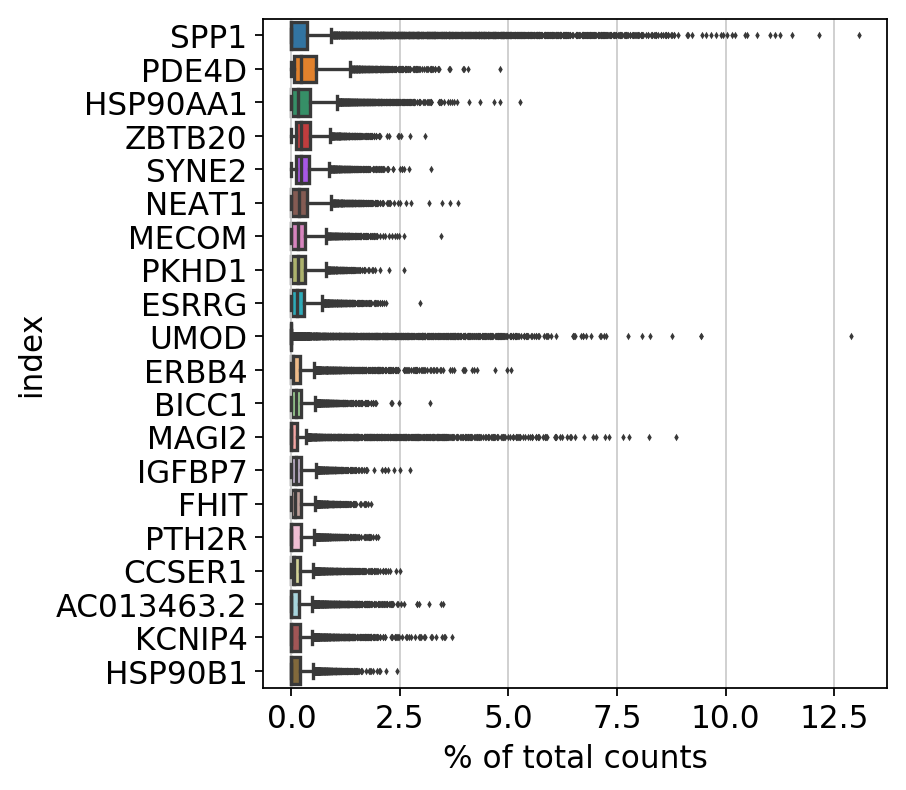

In [6]:
# Preprocessing
sc.pl.highest_expr_genes(adata, n_top=20, )

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1545 genes that are detected in less than 3 cells


In [8]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

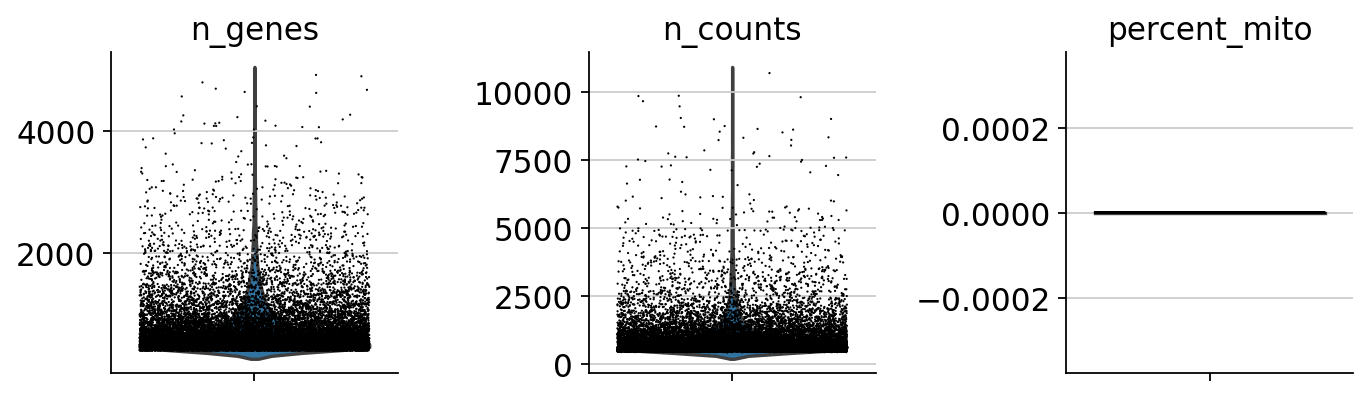

In [9]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

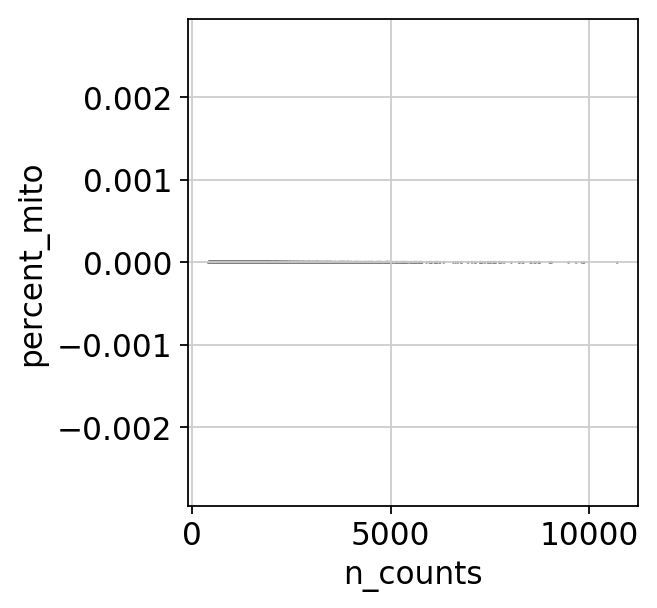

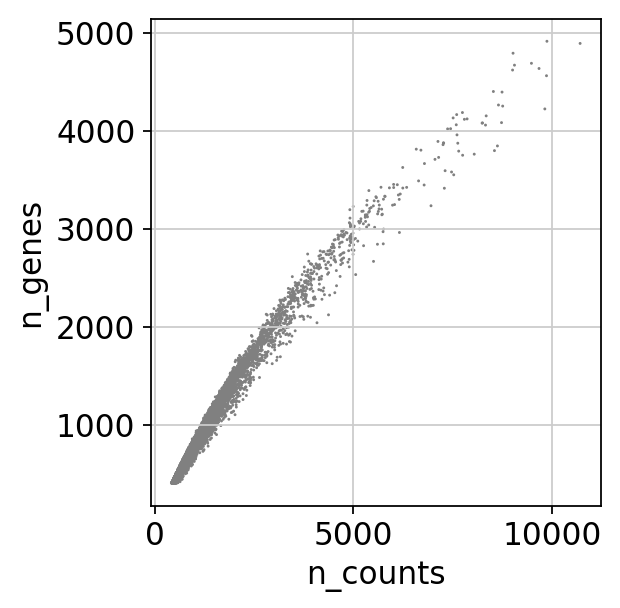

In [10]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [11]:
adata

AnnData object with n_obs × n_vars = 17659 × 29977 
    obs: 'Cluster', 'CellID', 'Abbn', 'Annotation', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [12]:
adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [13]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [14]:
adata.raw = adata

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


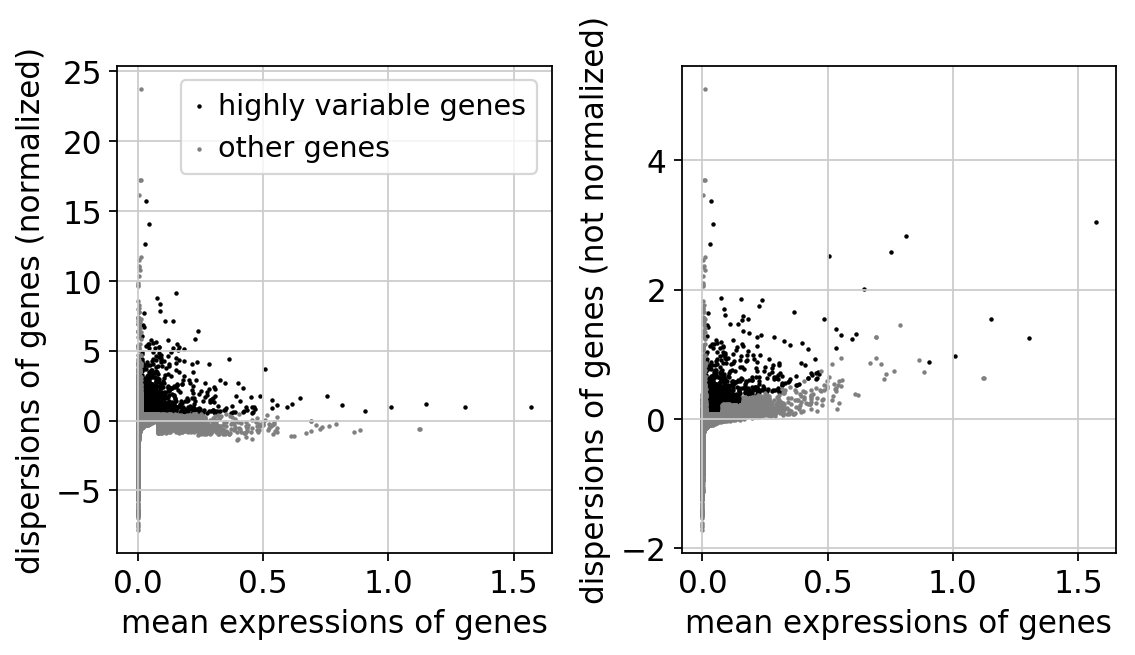

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata.var.highly_variable['ACE2']

True

In [18]:
adata = adata[:, adata.var.highly_variable]

In [19]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    finished (0:00:41.91)


In [20]:
sc.pp.scale(adata, max_value=10)

In [21]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=100)

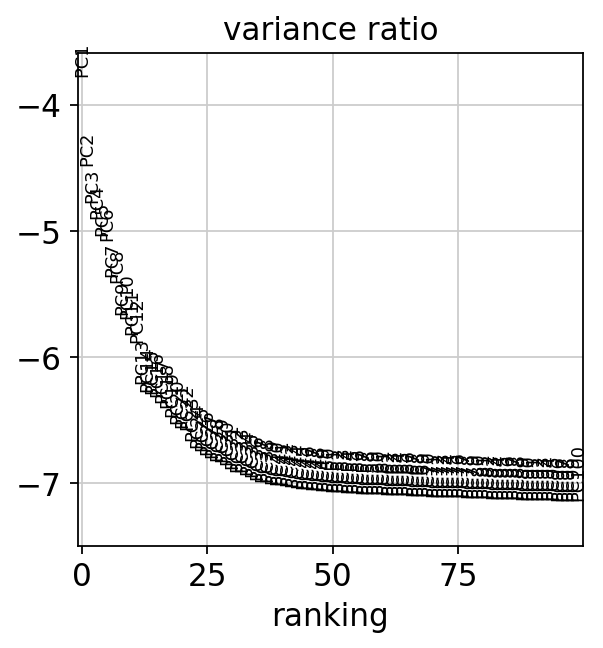

In [22]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)


In [23]:
sc.pp.neighbors(adata, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:10.19) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [24]:
sc.tl.tsne(adata, n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:01:39.31) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


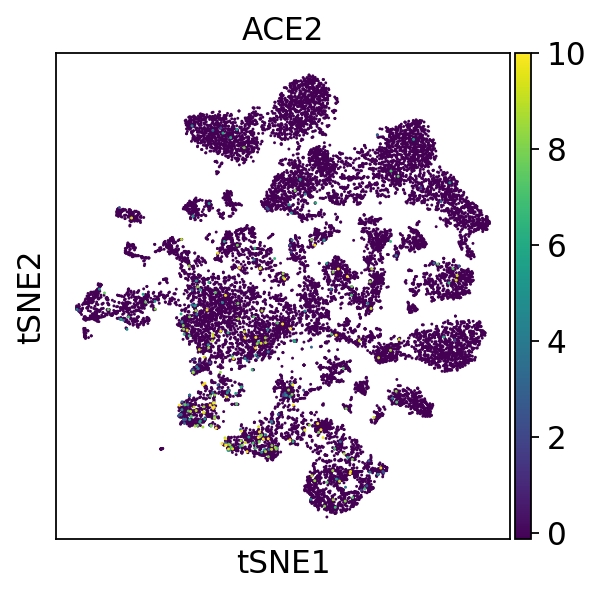

In [25]:
sc.pl.tsne(adata, color=['ACE2', "CUBN", "LRP2"], use_raw=False, color_map='viridis', save="1")

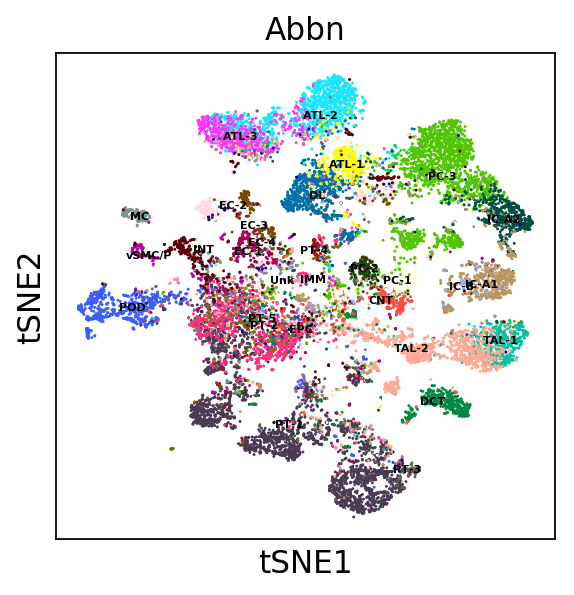

In [26]:
sc.pl.tsne(adata, color='Abbn', use_raw=False, legend_fontsize='10', legend_loc='on data', save="0")#

In [35]:
np.unique(adata.obs['Abbn'])

array(['ATL-1', 'ATL-2', 'ATL-3', 'CNT', 'DCT', 'DL', 'EC-1', 'EC-2',
       'EC-3', 'EC-4', 'EPC', 'IC-A1', 'IC-A2', 'IC-B', 'IMM', 'INT',
       'MC', 'PC-1', 'PC-2', 'PC-3', 'POD', 'PT-1', 'PT-2', 'PT-3',
       'PT-4', 'PT-5', 'TAL-1', 'TAL-2', 'Unk', 'vSMC/P'], dtype=object)

In [78]:
adata.var.loc['ACE2']

n_cells                   345
highly_variable          True
means               0.0167015
dispersions          0.160727
dispersions_norm     0.860289
Name: ACE2, dtype: object

In [72]:
PT_selector = adata.obs.index[adata.obs['Abbn'].isin(['PT-1', 'PT-2', 'PT-3', 'PT-4', 'PT-5'])]
ACE2_pos_selector = adata.obs.index[adata[:,'ACE2'].X > 0]
ACE2_neg_selector = adata.obs.index[adata[:,'ACE2'].X <= 0]

In [73]:
PT_ACE2_pos_selector = PT_selector.intersection(ACE2_pos_selector)
PT_ACE2_neg_selector = PT_selector.intersection(ACE2_neg_selector)

In [76]:
PT_selector, PT_ACE2_pos_selector, PT_ACE2_neg_selector

(Index(['C3_NK1_CGCTTTCATCTT', 'C3_NK1_CCGTCGACTATT', 'C3_NK1_GCCTTGTCCCAT',
        'C3_NK1_ACCGAAATTCAG', 'C3_NK1_CCGCTGCATGCC', 'C3_NK1_GGCGCACATCCC',
        'C3_NK1_ACTATCTTCGGT', 'C3_NK1_TCGAACACCATG', 'C3_NK1_TGAAGCTTCCAA',
        'C3_NK1_CTGAATCACGTG',
        ...
        'C7_NK92_TTTCGATACGGA', 'C7_NK93_GACACCTCTATN', 'C7_NK93_ACGCTCATCGGN',
        'C7_NK93_CCATGGCTCTTT', 'C7_NK93_TAGTTGTCGTCN', 'C7_NK93_TTTTCACCGTAN',
        'C7_NK93_CCCCGTTGCTTG', 'C7_NK94_AGCCGGTATGTA', 'C7_NK94_ACCCCTATCTTA',
        'C7_NK94_TTTTTCCCGTCT'],
       dtype='object', name='index', length=4557),
 Index(['C3_NK5_CGTTAAACCTCC', 'C3_NK9_GTCTACCTTCTA', 'C3_NK9_CACACTTGTCCT',
        'C3_NK9_GTTGCCATTTTA', 'C3_NK9_GGACGTTTGTAT', 'C3_NK9_GTCAAACGACTT',
        'C3_NK9_CAGCGTGACCTT', 'C3_NK9_CGACATTTGCTA', 'C3_NK9_ACAAATCCCTGT',
        'C3_NK9_CGTCGCTTCCTG',
        ...
        'C6_NK59_GGGTGCGCCTCG', 'C6_NK60_ACGAGAATAGTA', 'C7_NK21_CGCCTTTACTGT',
        'C7_NK25_TGGCAGGGGCGA', 'C7_NK29_CCCTCAC

In [86]:
adata.obs['PT_ACE'] = 'Not_PT'
adata.obs.loc[PT_ACE2_pos_selector, 'PT_ACE'] = 'PT_ACE2_pos'
adata.obs.loc[PT_ACE2_neg_selector, 'PT_ACE'] = 'PT_ACE2_neg'

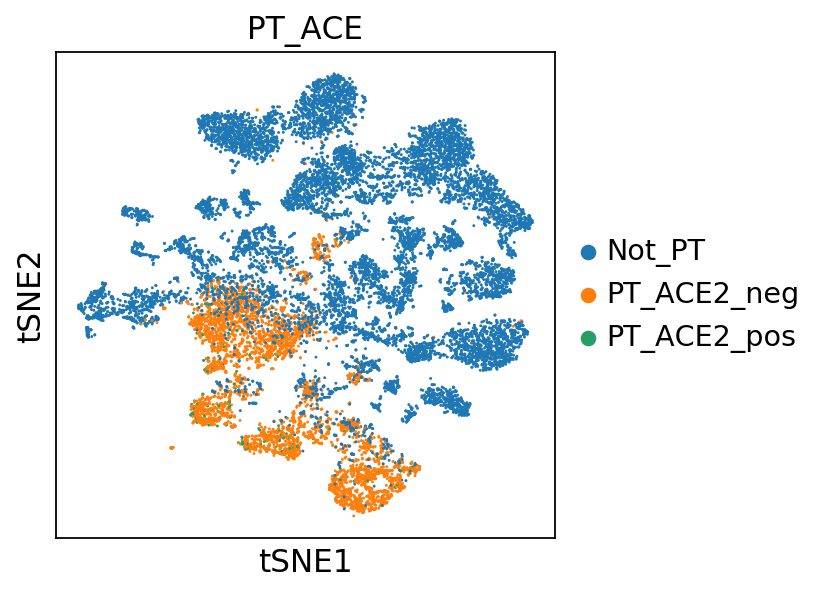

In [88]:
sc.pl.tsne(adata, color='PT_ACE', use_raw=False)#, legend_loc='on data', legend_fontsize='5')

ranking genes
    finished (0:00:50.38) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


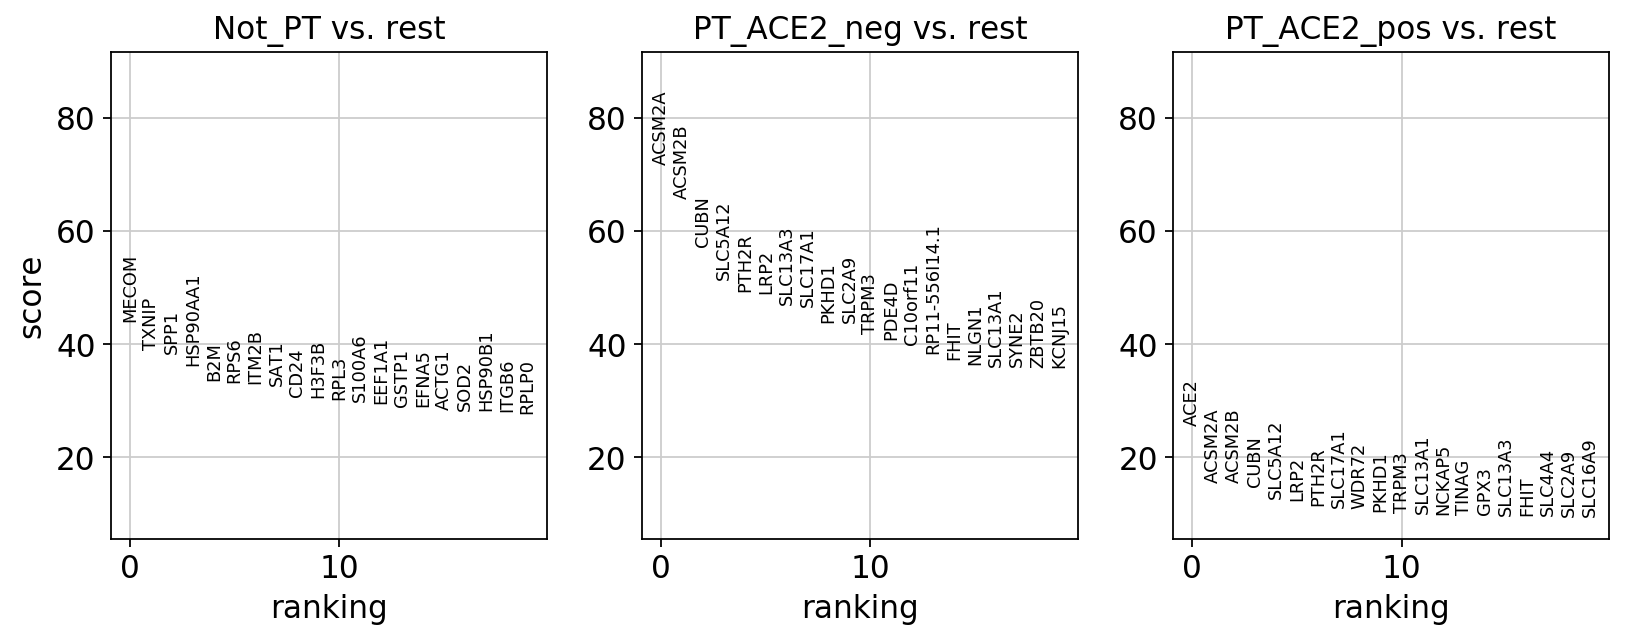

In [89]:
sc.tl.rank_genes_groups(adata, 'PT_ACE', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20)

ranking genes
    finished (0:00:10.67) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


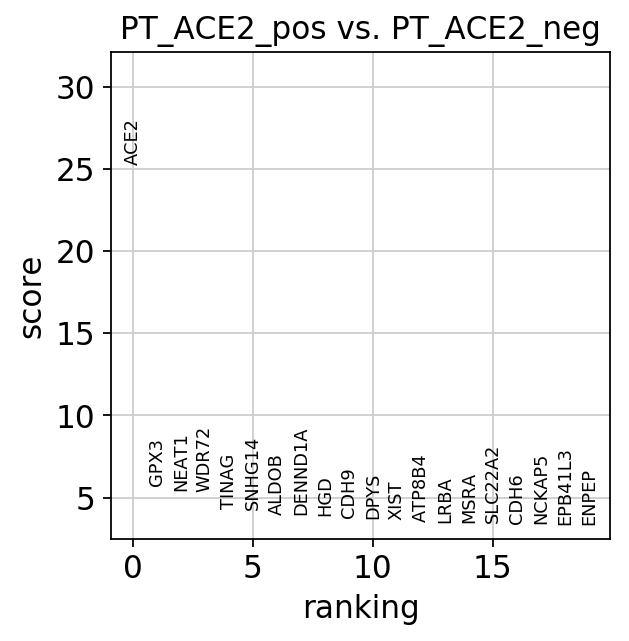

In [92]:
sc.tl.rank_genes_groups(adata, 'PT_ACE', groups=['PT_ACE2_pos'], reference='PT_ACE2_neg', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['PT_ACE2_pos'], n_genes=20)

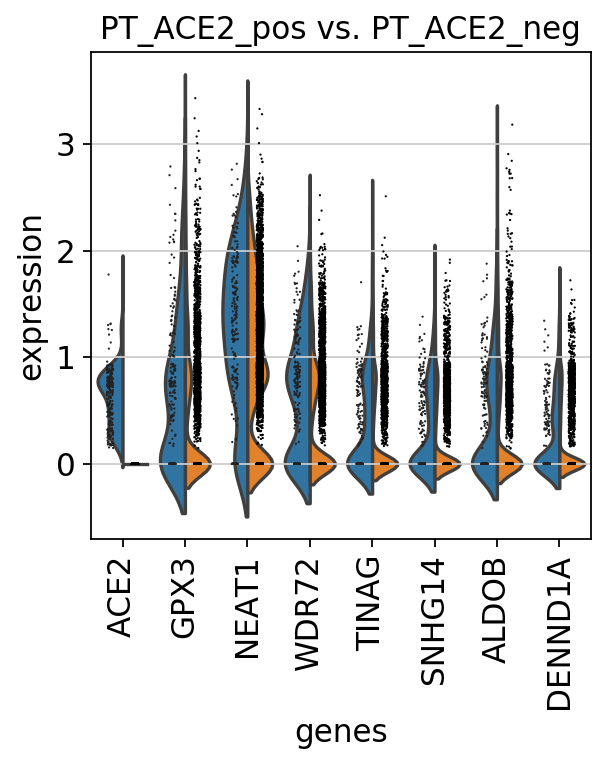

In [104]:
sc.pl.rank_genes_groups_violin(adata, groups='PT_ACE2_pos', n_genes=8)

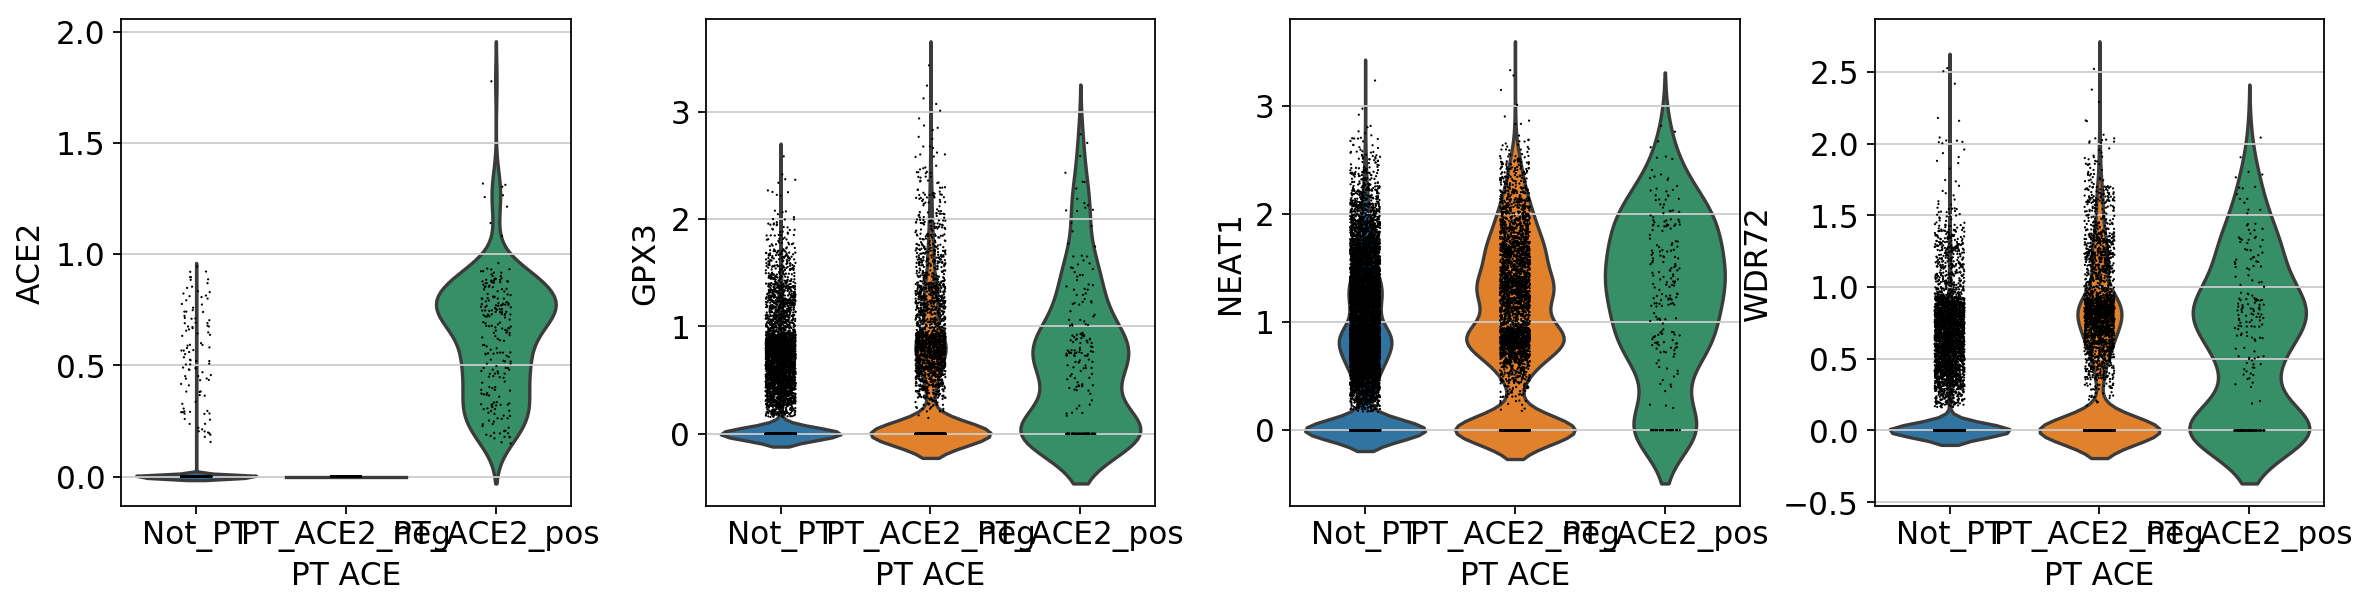

In [106]:
sc.pl.violin(adata, ['ACE2', 'GPX3', 'NEAT1', 'WDR72'], groupby='PT_ACE')

In [107]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

In [ ]:
result.pop('params')
df=pd.DataFrame(result).applymap(lambda x: x[0]).set_index('names')
df.to_csv("markers.csv")

In [109]:
adata

AnnData object with n_obs × n_vars = 17409 × 2015 
    obs: 'Cluster', 'CellID', 'Abbn', 'Annotation', 'n_genes', 'percent_mito', 'n_counts', 'PT_ACE'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'Abbn_colors', 'PT_ACE_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

In [101]:
adata.write("data/GSE121862/adata.h5ad")